In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import seaborn as sns
import datetime

from collections import Counter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import DBSCAN, KMeans, Birch, AgglomerativeClustering
from tqdm import tqdm

In [159]:
%pip install transformers umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00


In [2]:
!gdown 1Nwo_5m6jKiBhh-ftEbJ8EXb5jdl1bHRB

Downloading...
From: https://drive.google.com/uc?id=1Nwo_5m6jKiBhh-ftEbJ8EXb5jdl1bHRB
To: /content/results_triplets_sravni.csv
100% 7.58M/7.58M [00:00<00:00, 36.5MB/s]


## ***Готовим датасет***

In [103]:
res = pd.read_csv('results_triplets_sravni.csv')
triplets = res['pred_text'].values.tolist()
dates = pd.read_csv("/content/date.csv", header=None)
all_triplets = []
for i, label in enumerate(triplets):
    all_triplets.extend([list(item) + [dates.iloc[i, 0]] for item in eval(label)])

In [104]:
data = []
for triplet in all_triplets:
    at, ot, sp, ts = triplet
    at = at.lower()
    ot = ot.lower()

    data.append([ts, at, ot, sp, (at, ot, sp), (at, ot)])
data = pd.DataFrame(data)
data.columns = ['timestamp', 'aspect', 'opinion', 'sentiment', 'triplet', 'aspect_opinion']

## **Графики**

### ***Гистограмма тональности***

<Axes: >

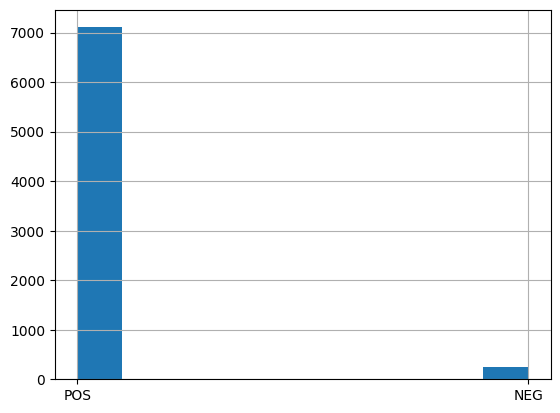

In [7]:
data['sentiment'].hist()

### ***Отнонешние тональностей с течением времени***

In [146]:
data_sorted = data.sort_values("timestamp", ascending=True)
data_sorted["date"] = data_sorted["timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).date())

def count_pos_neg(group):
  sent_dict = {"count_pos" : 0, "count_neg" : 0}
  for item in group:
    if item == "POS": sent_dict["count_pos"] += 1
    else: sent_dict["count_neg"] += 1
  return sent_dict
counted_sentiment = data_sorted.groupby("date")[["sentiment"]].agg(count_pos_neg).reset_index(names=["date"])

count_pos = 1; count_neg = 1;
ratio = []
for i, item in counted_sentiment.iterrows():
  count_pos += item["sentiment"]["count_pos"]
  count_neg += item["sentiment"]["count_neg"]
  ratio.append(count_pos / count_neg)

smoothing_k = 2
data_ratio = counted_sentiment[["date"]].iloc[::smoothing_k]
data_ratio["ratio: pos/neg"] = ratio[::smoothing_k]

In [147]:
fig = px.line(data_ratio, x="date", y="ratio: pos/neg")
fig.update_layout(scattermode="group")
fig.show()

### ***тональность по аспектам с течением времени***

In [154]:
# сюда вставить аспект
aspect = "приложение"
aspect_data = data.groupby("aspect").get_group(aspect).sort_values("timestamp")
aspect_data["date"] = aspect_data["timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
def count_pos_neg(group):
  sent_dict = {"count_pos" : 0, "count_neg" : 0}
  for item in group:
    if item == "POS": sent_dict["count_pos"] += 1
    else: sent_dict["count_neg"] += 1
  return sent_dict
counted_sentiment = aspect_data.groupby("date")[["sentiment"]].agg(count_pos_neg).reset_index(names=["date"])

count_pos = 1; count_neg = 1;
ratio = []
for i, item in counted_sentiment.iterrows():
  count_pos += item["sentiment"]["count_pos"]
  count_neg += item["sentiment"]["count_neg"]
  ratio.append(count_pos / count_neg)

smoothing_k = 1
data_ratio = counted_sentiment[["date"]].iloc[::smoothing_k]
data_ratio["ratio: pos/neg"] = ratio[::smoothing_k]

In [155]:
fig = px.line(data_ratio, x="date", y="ratio: pos/neg", title=f"график отношений сентиментов аспектa {aspect}")
fig.update_layout(scattermode="group")
fig.show()

*идея: попробовать выделять сезонность в данном графике*

### ***самые частые триплеты***

In [8]:
Counter(data.triplet).most_common(10)

[(('банк', 'лучший', 'POS'), 275),
 (('приложение', 'удобное', 'POS'), 123),
 (('банку', 'спасибо', 'POS'), 90),
 (('банк', 'рекомендую', 'POS'), 76),
 (('менеджеру', 'благодарность', 'POS'), 74),
 (('банк', 'отличный', 'POS'), 69),
 (('решение', 'оперативное', 'POS'), 66),
 (('обслуживание', 'бесплатное', 'POS'), 63),
 (('решение', 'быстрое', 'POS'), 53),
 (('сотруднику', 'благодарность', 'POS'), 51)]

### ***Гисторгамма самых негативных аспектов***

<Axes: title={'center': 'кол-во негативных отзывов по аспектам'}, xlabel='aspect'>

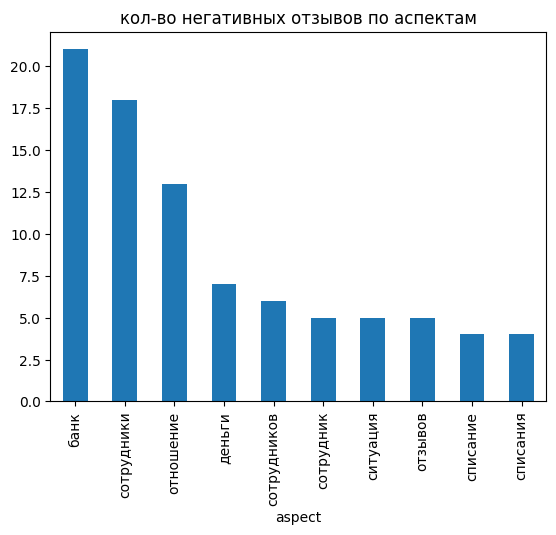

In [ ]:
data[data.sentiment=='NEG'].groupby('aspect').size().sort_values(ascending=False).iloc[:10].plot(kind='bar', y="count",  title="кол-во негативных отзывов по аспектам", label="aspect")

### ***Гисторгамма самых положительных аспектов***

<Axes: title={'center': 'кол-во положительный отзывов по аспектам'}, xlabel='aspect'>

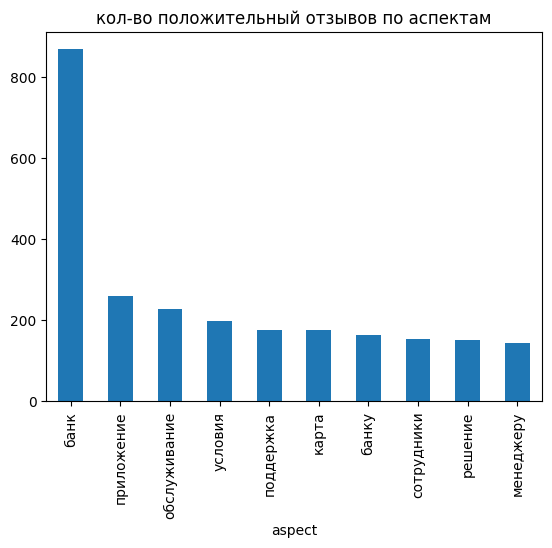

In [ ]:
data[data.sentiment=='POS'].groupby('aspect').size().sort_values(ascending=False).iloc[:10].plot(kind="bar", y="count", title="кол-во положительный отзывов по аспектам", label="aspect")

### ***Посмотрим то же самое в доле положительных триплетов***

#### **по убыванию**

In [ ]:
def get_part_of_pos_sentiments(x):
    if len(x) >= 20:
        return len(x[x=='POS'])/len(x)
    else:
        return 0.5

sentiment = data.groupby('aspect').agg({'sentiment': get_part_of_pos_sentiments})['sentiment'].sort_values(ascending=False).to_dict()

{'приложение': 1.0,
 'кэшбэк': 1.0,
 'оператору': 1.0,
 'банком': 1.0,
 'банку': 1.0,
 'персонал': 1.0,
 'мобильное': 1.0,
 'бонус': 1.0,
 'работой': 1.0,
 'предложения': 1.0}

### ***Гистограмма популярности пар аспект-мнение***

In [ ]:
data["aspect_opinion"] = data["aspect_opinion"].apply(lambda x: x[0]+"-"+x[1])

<Axes: xlabel='pair name'>

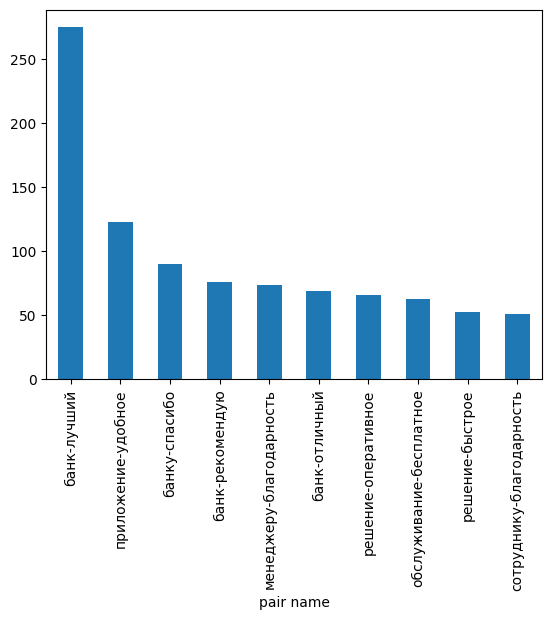

In [ ]:
most_common_pairs = pd.DataFrame(Counter(data["aspect_opinion"]).most_common(10), columns=["pair", "count"])
most_common_pairs_series = pd.Series(list(most_common_pairs["count"]), index=list(most_common_pairs["pair"]))
most_common_pairs_series.plot(kind="bar", xlabel="pair name", y="count")

### ***Облака слов для аспектов и мнений***

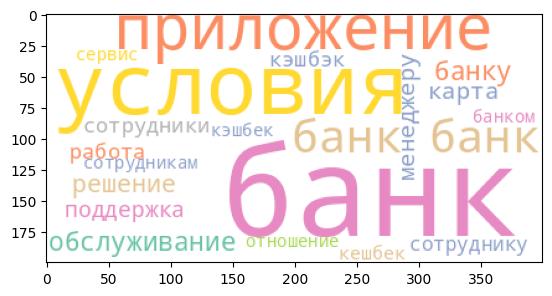

In [ ]:
cloud_aspect = WordCloud(background_color="#ffffff", contour_width=20, contour_color='#2e3043', colormap="Set2", max_words=20).generate(text=' '.join(data["aspect"]))
plt.imshow(cloud_aspect)
plt.show()

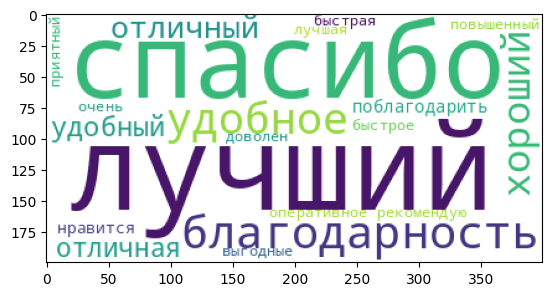

In [ ]:
cloud_opinion = WordCloud(background_color="#ffffff", max_words=20).generate(text=' '.join(data["opinion"]))
plt.imshow(cloud_opinion)
plt.show()

### **Класстеризация аспектов**

In [156]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [157]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny-sentiment-balanced")

model.to(device)

aspects = set(data.aspect.tolist())
embeddings = []

for aspect in tqdm(aspects):

    encoded_input = tokenizer(aspect, padding=False, return_tensors='pt').to(device)

    with torch.no_grad():
        model_output = model(**encoded_input)

    embeddings.append(model_output.last_hidden_state.mean(dim=1))

embeddings = torch.stack(embeddings).cpu().numpy().squeeze(1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

100%|██████████| 806/806 [00:08<00:00, 98.62it/s] 


In [160]:
import umap

reducer8 = umap.UMAP(n_components=8)
reducer2 = umap.UMAP(n_components=2)

In [161]:
# embeds_reduced8 = reducer8.fit_transform(embeddings)
# embeds_reduced2 = reducer2.fit_transform(embeds_reduced8)

embeds_reduced8 = reducer8.fit_transform(embeddings)
embeds_reduced2 = reducer2.fit_transform(embeddings)

In [162]:
# clusters = DBSCAN(n_jobs=-1, min_samples=4).fit(embeds_reduced8)
# clusters_kmeans = KMeans(n_clusters=25).fit(embeds_reduced8)
# clusters_birch = Birch(n_clusters=None).fit(embeds_reduced8)
clusters_agglo = AgglomerativeClustering(n_clusters=None, distance_threshold=3).fit(embeds_reduced8)

In [163]:
df = pd.DataFrame(embeds_reduced2[:, 0], columns=["x"])
df["y"] = embeds_reduced2[:, 1]; df["color"] = clusters_agglo.labels_; df["aspect"] = list(aspects); df["size"] = df["aspect"].apply(lambda x: len(data[data.aspect == x]) / 10)
# px.scatter(df, x="x", y="y", color="color", hover_data={"text": df["aspect"]}, size="size")
px.scatter(df, x="x", y="y", color="color", hover_data={"text": df["aspect"]})

# **Вывод**

*Как мы видим, у пользователей нет нареканий касательно приложения, кэшбека, операторов и самого банка. Но вот сотрудники и менеджеры иногда портят их впечатление о банке*